<a href="https://colab.research.google.com/github/lacykaltgr/agriculture-image-processing/blob/SatiX/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch

for i in range(torch.cuda.device_count()):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=9,
                 hiddens=None, dropouts=None, kernel_sizes=None, maxpools=None, paddings=None, strides=None,
                 criterion=nn.CrossEntropyLoss(), activation=nn.ReLU(), output_activation=nn.Softmax(dim=1),
                 pre_process=None, post_process=None, dimensions=2, device='cuda'):
        super(UNet, self).__init__()

        if dimensions == 2:
            conv = nn.Conv2d
            batchnorm = nn.BatchNorm2d
            dropout = nn.Dropout2d
            maxpool = nn.MaxPool2d
        elif dimensions == 3:
            conv = nn.Conv3d
            batchnorm = nn.BatchNorm3d
            dropout = nn.Dropout3d
            maxpool = nn.MaxPool3d
        else:
            raise ValueError('Only 2D and 3D convolutions are supported')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.criterion = criterion
        self.pre_process = pre_process if pre_process is not None else lambda x: x
        self.post_process = post_process if post_process is not None else lambda x: x
        self.device = device

        # channels
        if hiddens is None:
            hiddens = [64]
        elif isinstance(hiddens, int):
            hiddens = [hiddens]
        elif isinstance(hiddens, list):
            assert len(hiddens) > 0, "Number of hiddens must be greater than 0"
        else:
            raise ValueError("Hiddens must be an integer or a list of integers")
        channels_downsample = [in_channels] + hiddens
        self.n_downsamples = len(channels_downsample) - 1
        channels_upsample = hiddens[::-1] + [out_channels]
        self.n_upsamples = len(channels_upsample) - 2

        # dropouts
        if dropouts is None:
            dropouts = [0] * self.n_downsamples
        elif isinstance(dropouts, float):
            dropouts = [dropouts] * self.n_downsamples
        elif isinstance(dropouts, list):
            assert len(dropouts) == self.n_downsamples, \
                "Number of dropouts must match the number of downsamples"
        else:
            raise ValueError("Dropouts must be a float or a list of floats")

        # maxpools
        if maxpools is None:
            maxpools = [2] * self.n_downsamples
        elif isinstance(maxpools, int):
            maxpools = [maxpools] * self.n_downsamples
        elif isinstance(maxpools, tuple):
            maxpools = [maxpools] * self.n_downsamples
        elif isinstance(maxpools, list):
            assert len(maxpools) == self.n_downsamples, \
                "Number of maxpools must match the number of downsamples"
        else:
            raise ValueError("Maxpools must be an integer, a tuple of integers or a list of integers")

        n_enc_convolutions = 2 * self.n_downsamples
        n_dec_convolutions = 3 * self.n_upsamples + 2
        # kernel_sizes
        if kernel_sizes is None:
            kernel_sizes = [[3] * n_enc_convolutions, [3] * n_dec_convolutions]
        elif isinstance(kernel_sizes, int):
            kernel_sizes = [[kernel_sizes] * n_enc_convolutions, [kernel_sizes] * n_dec_convolutions]
        elif isinstance(kernel_sizes, tuple):
            kernel_sizes = [[kernel_sizes] * n_enc_convolutions, [kernel_sizes] * n_dec_convolutions]
        elif isinstance(kernel_sizes, list):
            assert len(kernel_sizes) == 2, \
                "Number of kernel_sizes must be organized into encoder, decoder kernel sizes"
            assert len(kernel_sizes[0]) == n_enc_convolutions, \
                "Number of encoder kernel_sizes must match the number of encoder convolutions"
            assert len(kernel_sizes[1]) == n_dec_convolutions, \
                "Number of decoder kernel_sizes must match the number of decoder convolutions"
        else:
            raise ValueError("Kernel_sizes must be an integer, a tuple of integers or a list of integers")

        enc_kernel_sizes, dec_kernel_sizes = kernel_sizes

        if paddings is None:
            paddings = [['same'] * n_enc_convolutions, ['same'] * n_dec_convolutions]
        elif isinstance(paddings, str):
            paddings = [[paddings] * n_enc_convolutions, [paddings] * n_dec_convolutions]
        elif isinstance(paddings, tuple):
            paddings = [[paddings] * n_enc_convolutions, [paddings] * n_dec_convolutions]
        elif isinstance(paddings, int):
            paddings = [[paddings] * n_enc_convolutions, [paddings] * n_dec_convolutions]
        elif isinstance(paddings, list):
            assert len(paddings) == 2, \
                "Number of paddings must be organized into encoder, decoder paddings"
            assert len(paddings[0]) == n_enc_convolutions, \
                "Number of encoder paddings must match the number of encoder convolutions"
            assert len(paddings[1]) == n_dec_convolutions, \
                "Number of decoder paddings must match the number of decoder convolutions"
        else:
            raise ValueError("Paddings must be an integer, a tuple of integers or a list of integers")
        enc_paddings, dec_paddings = paddings

        if strides is None:
            strides = [[1] * n_enc_convolutions, [1] * n_dec_convolutions]
        elif isinstance(strides, int):
            strides = [[strides] * n_enc_convolutions, [strides] * n_dec_convolutions]
        elif isinstance(strides, tuple):
            strides = [[strides] * n_enc_convolutions, [strides] * n_dec_convolutions]
        elif isinstance(strides, list):
            assert len(strides) == 2, \
                "Number of strides must be organized into encoder, decoder strides"
            assert len(strides[0]) == n_enc_convolutions, \
                "Number of encoder strides must match the number of encoder convolutions"
            assert len(strides[1]) == n_dec_convolutions, \
                "Number of decoder strides must match the number of decoder convolutions"
        else:
            raise ValueError("Strides must be an integer, a tuple of integers or a list of integers")
        enc_strides, dec_strides = strides

        self.layers_upsample = nn.ModuleDict()
        self.layers_downsample = nn.ModuleDict()

        # Left side of the U-Net
        for i in range(self.n_downsamples):
            self.layers_downsample[f"conv_enc_{i}_1"] = \
                conv(channels_downsample[i], channels_downsample[i + 1],
                     kernel_size=enc_kernel_sizes[2 * i], padding=enc_paddings[2 * i], stride=enc_strides[2 * i])

            self.layers_downsample[f"conv_enc_{i}_2"] = \
                conv(channels_downsample[i + 1], channels_downsample[i + 1],
                     kernel_size=enc_kernel_sizes[2 * i + 1], padding=enc_paddings[2 * i + 1],
                     stride=enc_strides[2 * i + 1])

            self.layers_downsample[f"batchnorm_enc_{i}"] = \
                batchnorm(channels_downsample[i + 1])

            self.layers_downsample[f"dropout_{i}"] = \
                dropout(p=dropouts[i])

            if i != self.n_downsamples - 1:  # utsonak nem kell
                self.layers_downsample[f"maxpool_{i}"] = maxpool(maxpools[i])

        # Up-sampling starts, right side of the U-Net
        for i in range(self.n_upsamples):
            self.layers_upsample[f"upconv_dec_{i}"] = \
                conv(channels_upsample[i], channels_upsample[i + 1],
                     kernel_size=dec_kernel_sizes[3 * i], padding=dec_paddings[3 * i], stride=dec_strides[3 * i])

            self.layers_upsample[f"conv_dec_{i}_1"] = \
                conv(channels_upsample[i], channels_upsample[i + 1],
                     kernel_size=dec_kernel_sizes[3 * i + 1], padding=dec_paddings[3 * i + 1],
                     stride=dec_strides[3 * i + 1])

            self.layers_upsample[f"conv_dec_{i}_2"] = \
                conv(channels_upsample[i + 1], channels_upsample[i + 1],
                     kernel_size=dec_kernel_sizes[3 * i + 2], padding=dec_paddings[3 * i + 2],
                     stride=dec_strides[3 * i + 2])

            if i == self.n_upsamples - 1:
                self.layers_upsample[f"conv_dec_{i}_3"] = \
                    conv(channels_upsample[i + 1], channels_upsample[i + 1],
                         kernel_size=dec_kernel_sizes[3 * i + 3], padding=dec_paddings[3 * i + 3],
                         stride=dec_strides[3 * i + 3])
            self.layers_upsample[f"batchnorm_dec_{i}"] = batchnorm(channels_upsample[i + 1])
            #else:
            #    self.layers_upsample[f"batchnorm_dec_{i}"] = batchnorm(channels_upsample[i + 1])

        # Output layer of the U-Net with a softmax activation
        self.layers_upsample["conv_out"] = \
            conv(channels_upsample[-2], channels_upsample[-1],
                 kernel_size=dec_kernel_sizes[-1], padding=dec_paddings[-1], stride=dec_strides[-1])
        self.output_activation = output_activation
        self.activation = activation

        # initialize all parameters with xavier uniform
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        skip_connections = []
        # Left side of the U-Net
        for i in range(self.n_downsamples):
            x = self.activation(self.layers_downsample[f"conv_enc_{i}_1"](x))
            x = self.activation(self.layers_downsample[f"conv_enc_{i}_2"](x))
            x = self.layers_downsample[f"batchnorm_enc_{i}"](x)
            x = self.layers_downsample[f"dropout_{i}"](x)

            if i != self.n_downsamples - 1:
                skip_connections.append(x)
                x = self.layers_downsample[f"maxpool_{i}"](x)

        # Upsampling Starts, right side of the U-Net
        for i in range(self.n_upsamples):
            skip = skip_connections.pop()
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
            x = self.activation(self.layers_upsample[f"upconv_dec_{i}"](x))
            x = torch.cat([skip, x], dim=1)
            x = self.activation(self.layers_upsample[f"conv_dec_{i}_1"](x))
            x = self.activation(self.layers_upsample[f"conv_dec_{i}_2"](x))

            if i == self.n_upsamples - 1:
                x = self.activation(self.layers_upsample[f"conv_dec_{i}_3"](x))
            x = self.layers_upsample[f"batchnorm_dec_{i}"](x)

        # Output layer of the U-Net with a softmax activation
        out_conv = self.layers_upsample["conv_out"](x)
        y = self.output_activation(out_conv)
        return y

    def train_model(self, train_loader, valid_loader, early_stopper,
                    num_epochs=100, learning_rate=1e-4, weight_decay=1e-5, device='cuda'):
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train_loss = valid_loss = []
        for epoch in range(num_epochs):
            epoch_train_loss = correct_train = total_train = 0
            self.train()
            for batch in train_loader:
                optimizer.zero_grad()
                inputs, targets = batch
                inputs, targets = inputs.to(device).float(), targets.to(device).float()
                outputs = self(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

                c, t = self._accuracy_score(targets, outputs)
                correct_train += c
                total_train += t

                outputs.detach().cpu()
                targets.detach().cpu()

            train_accuracy = 100 * correct_train / total_train

            epoch_valid_loss, valid_accuracy = self.evaluate(valid_loader, device=device)

            epoch_train_loss /= len(train_loader)
            epoch_valid_loss /= len(valid_loader)
            train_loss.append(epoch_train_loss)
            valid_loss.append(epoch_valid_loss)
            print(
                f'Epoch {epoch + 1:03}: | Train Loss: {epoch_train_loss:.5f} | Validation Loss: {epoch_valid_loss:.5f}'
                + f' | Train Acc: {train_accuracy:.2f}% | Valid Acc: {valid_accuracy:.2f}%')

            if early_stopper.early_stop(epoch_valid_loss):
                break
        return train_loss, valid_loss

    def predict(self, test_loader, device='cuda'):
        self.eval()
        raw_predictions = []
        with torch.no_grad():
            for batch in test_loader:
                inputs, _ = batch
                inputs = self.pre_process(inputs).to(device)
                outputs = self(inputs)
                _, preds = torch.max(outputs, 1)
                raw_predictions.append(preds.detach().cpu().numpy())
        results = []
        for batch in raw_predictions:
            for img in batch:
                results.append(self.post_process(img))
        return results, raw_predictions

    def evaluate(self, test_loader, device='cuda'):
        epoch_valid_loss = 0
        self.eval()
        correct_valid = 0
        total_valid = 0
        for batch in test_loader:
            inputs, targets = batch
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()
            outputs = self(inputs)
            loss = self.criterion(outputs, targets)
            epoch_valid_loss += loss.item()

            c, t = self._accuracy_score(targets, outputs)
            correct_valid += c
            total_valid += t

            outputs.detach().cpu()
            targets.detach().cpu()

        valid_accuracy = 100 * correct_valid / total_valid
        return epoch_valid_loss, valid_accuracy

    def summary(self, input_shape):
        from torchinfo import summary
        return summary(self, input_size=input_shape)

    @staticmethod
    def _accuracy_score(y_true, y_pred):
        if y_true.shape[1] == 1:
            total = np.prod(y_true.size())
            correct = torch.sum(y_pred.round() == y_true).item()
            return correct, total
        else:
            _, acc_predictions = torch.max(y_pred, 1)
            _, acc_targets = torch.max(y_true, 1)
            total = np.prod(acc_targets.size())
            correct = (acc_predictions == acc_targets).sum().item()
            return correct, total




class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

GPU 0: NVIDIA A100-SXM4-40GB


In [2]:
!pip install -U typing-extensions

In [3]:
!pip install segments-ai
!pip install -U typing-extensions

from segments import SegmentsClient
import numpy as np
from segments.utils import load_image_from_url, load_label_bitmap_from_url, get_semantic_bitmap


api_key = "8243f2013ed15d1e28aaa42d52a8447f9bbe4dfb"

client = SegmentsClient(api_key)

dataset = 'laszlofreund/tree_trunk'

x = []
y = []

color_dict = {
    0: np.array([255, 0, 0]),
    1: np.array([0, 255, 0]),
    2: np.array([0, 0, 255])
}


def num_to_onehot(num_arr: np.array, color_dict):
    identity_matrix = np.eye(len(color_dict))
    one_hot_encoded = identity_matrix[num_arr]
    return one_hot_encoded



def onehot_to_rgb(onehot):
    num = np.argmax(onehot, 2)
    output = np.zeros(num.shape+(3,))
    for k in color_dict.keys():
        output[onehot == k] = color_dict[k].numpy()
    return np.uint8(output)

for sample in client.get_samples(dataset):
    label = client.get_label(sample.uuid, labelset='ground-truth')
    image = load_image_from_url(sample.attributes.image.url)
    label = load_label_bitmap_from_url(label.attributes.segmentation_bitmap.url)

    x.append(np.array(image, dtype='uint8'))
    y.append(np.array(label, dtype='uint8'))

#np.save("x.npy", np.stack(x))
#np.save("y.npy", np.stack(y))

In [4]:
#x_data = np.load(os.path.join(root, 'x.npy'))
#y_data = np.float32(np.load(os.path.join(root, 'y.npy')))

x_data = np.stack(x)
y_data = np.stack(y)[..., np.newaxis]

print(y_data.shape)

print("Data loaded...")
print(x_data.shape, y_data.shape)

x_data = np.transpose(x_data, (0, 3, 2, 1))
y_data = np.transpose(y_data, (0, 3, 2, 1))
#print(x_data.shape)

#x_mean = np.mean(x_data, axis=(0, 2, 3), keepdims=True)
#x_std = np.std(x_data, axis=(0, 2, 3), keepdims=True)
#x_data = (x_data - x_mean) / (x_std + 1e-7)

print("Data processed...")

split = int(len(x_data) * 0.9)
x_train = x_data[:split]
y_train = y_data[:split]

flip_x = np.flip(x_train, 2)
flip_y = np.flip(y_train, 2)
print(flip_x.shape)
x_train = np.concatenate([x_train, flip_x], axis=0)
y_train = np.concatenate([y_train, flip_y], axis=0)
#x_train = augment_dataset_with_labels(x_train, y_train)
#y_train = augment_dataset_with_labels(x_train, y_train)

#x_train, y_train = augment_dataset_with_labels(x_train, y_train)
print("Data augmented...")

x_val = x_data[split:]
y_val = y_data[split:]

(23, 3000, 4000, 1)
Data loaded...
(23, 3000, 4000, 3) (23, 3000, 4000, 1)
Data processed...
(20, 3, 4000, 3000)
Data augmented...


In [5]:
print(x_train.shape)

(40, 3, 4000, 3000)


In [6]:
colab = True
jupyter_server = False

if colab:
    #from google.colab import drive
    #drive.mount('/content/drive')
    root = '/content/tree_trunk_segmentation/data/'
    device = 'cuda'
    #!wget -O treetrunk.zip https://github.com/lacykaltgr/agriculture-image-processing/archive/refs/heads/laci420.zip
    #!unzip treetrunk.zip
    #!cp -r agriculture-image-processing-laci420/tree_trunk_segmentation/ .
    #!cp agriculture-image-processing-laci420/unet.py .
    #!cp agriculture-image-processing-laci420/utils.py .

elif jupyter_server:
    import sys
    import os
    root = ''
    device = 'cuda'
    parent_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))
    sys.path.append(parent_directory)
else:
    import sys
    import os
    root = 'data/'
    device = 'mps'
    #parent_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))
    #sys.path.append(parent_directory)

In [7]:
from torch.utils.data import DataLoader, Dataset

class XYDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_data[idx]).float()
        #y_binary = rgb_to_binary(self.y_data[idx], color_dict)
        y = torch.tensor(self.y_data[idx]).float()
        return x, y

#x_train, y_train, x_val, y_val, x_mean, x_std  = load_dataset(root=root, val_split_ratio=0.9)

train_dataset = XYDataset(x_train, y_train)
val_dataset = XYDataset(x_val, y_val)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

In [8]:
len(train_dataset)

40

In [53]:
import torch
from torch import nn

config = dict(
    in_channels=3,
    out_channels=1,
    hiddens=[4, 8, 16, 32],
    dropouts=[0, 0, 0.3, 0.3],  # hiddens
    maxpools=2,  # hiddens - 1
    kernel_sizes=3,  # 2*hiddens + 3*hiddens + 2
    paddings='same',  # 2*hiddens + 3*hiddens + 2
    strides=1,  # 2*hiddens + 3*hiddens
    criterion=nn.BCELoss(),
    output_activation=nn.Sigmoid(),
    activation=nn.ReLU(),
    dimensions=2,
    device=device
)
unet = UNet(**config).to(device)

In [10]:
unet.summary(input_shape=(1, 3, 4000, 3000))

ModuleNotFoundError: ignored

In [54]:
es = EarlyStopper(patience=10)
unet.train_model(train_loader, val_loader, es, num_epochs=1000, learning_rate=0.002, device=device)

Epoch 001: | Train Loss: 0.71477 | Validation Loss: 0.63225 | Train Acc: 54.19% | Valid Acc: 66.64%
Epoch 002: | Train Loss: 0.64215 | Validation Loss: 0.51241 | Train Acc: 62.04% | Valid Acc: 69.75%
Epoch 003: | Train Loss: 0.56868 | Validation Loss: 0.47639 | Train Acc: 73.96% | Valid Acc: 74.36%
Epoch 004: | Train Loss: 0.51338 | Validation Loss: 0.36124 | Train Acc: 81.86% | Valid Acc: 85.99%
Epoch 005: | Train Loss: 0.46609 | Validation Loss: 0.49035 | Train Acc: 84.69% | Valid Acc: 80.37%
Epoch 006: | Train Loss: 0.43625 | Validation Loss: 0.39737 | Train Acc: 85.62% | Valid Acc: 86.77%
Epoch 007: | Train Loss: 0.39915 | Validation Loss: 0.34005 | Train Acc: 86.47% | Valid Acc: 86.05%
Epoch 008: | Train Loss: 0.39049 | Validation Loss: 0.37029 | Train Acc: 86.82% | Valid Acc: 85.96%
Epoch 009: | Train Loss: 0.35107 | Validation Loss: 0.35697 | Train Acc: 87.05% | Valid Acc: 86.66%
Epoch 010: | Train Loss: 0.33316 | Validation Loss: 0.31131 | Train Acc: 87.67% | Valid Acc: 87.71%


KeyboardInterrupt: ignored

In [23]:
!pip install kornia
import kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 11.2 MB/s eta 0:00:00


In [40]:
class TVDenoiser:
    def __init__(self, n_iters, regularization_scaler=0.0001,  lr=0.1):
        self.l2_term = torch.nn.MSELoss(reduction='mean')
        self.regularization_term = kornia.losses.TotalVariation()

        self.regularization_scaler = regularization_scaler
        self.num_iters = n_iters
        self.lr = lr

    def loss(self, clean_image, noisy_image):
        return self.l2_term(clean_image, noisy_image) + \
            self.regularization_scaler * self.regularization_term(clean_image)

    def forward(self, noisy_image):
        clean_image = torch.nn.Parameter(data=noisy_image.clone(), requires_grad=True)
        optimizer = torch.optim.Adam([clean_image], lr=self.lr)
        for i in range(self.num_iters):
            optimizer.zero_grad()
            loss = self.loss(clean_image, noisy_image)
            loss.backward()
            optimizer.step()
        return clean_image.detach().cpu().numpy()

In [65]:
pred = unet(val_dataset[0][0].cuda().unsqueeze(0)).detach().cpu().numpy()
bin = (pred > 0.6).astype(int)[0]

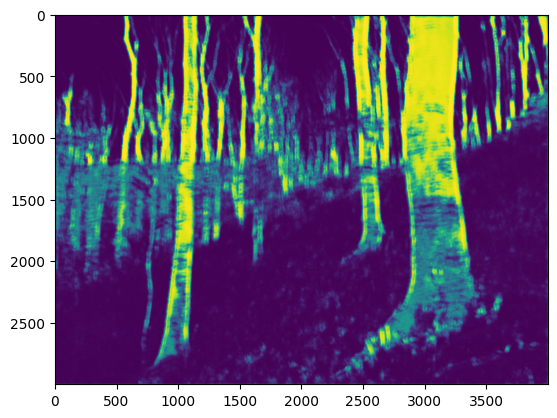

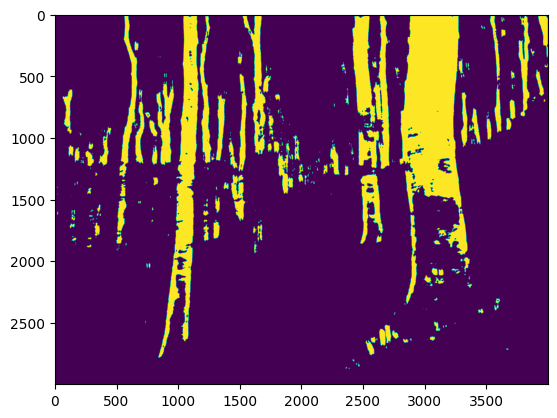

In [66]:
from matplotlib.pyplot import show, imshow
imshow(np.transpose(pred[0], (2,1,0)))
show()

imshow(np.transpose(bin, (2,1,0)))
show()

In [31]:
result = pred[0]

In [48]:
denoiser = TVDenoiser(1000, regularization_scaler=0.01, lr=0.1)

In [49]:
clean = denoiser.forward(torch.tensor(result))

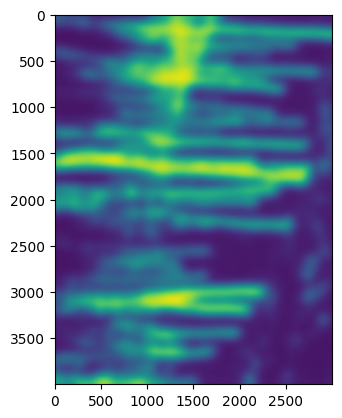

In [50]:
from matplotlib.pyplot import imshow, show
imshow(clean[0])
show()

In [51]:
torch.save(unet, "model.pth")

AttributeError: ignored

In [ ]:
predictions, results = unet.predict(val_loader, device=device)

In [ ]:
unet.load_state_dict(torch.load('/Users/laszlofreund/code/ai/satellite-image-segmentation/unet.h5', map_location=device))

In [ ]:
eval = unet.evaluate(val_loader, device=device)

torch.Size([1, 1, 4000, 500]) torch.Size([1, 1, 4000, 500])
tensor([[[[False, False, False,  ..., False, False,  True],
          [ True, False, False,  ...,  True, False, False],
          [False,  True, False,  ..., False, False, False],
          ...,
          [False, False, False,  ...,  True, False, False],
          [False,  True, False,  ..., False, False, False],
          [False, False,  True,  ..., False,  True,  True]]]], device='mps:0')
torch.Size([1, 1, 4000, 500]) torch.Size([1, 1, 4000, 500])
tensor([[[[ True, False, False,  ..., False, False, False],
          [False, False, False,  ...,  True, False, False],
          [False, False, False,  ...,  True,  True,  True],
          ...,
          [False, False, False,  ...,  True, False, False],
          [ True, False, False,  ..., False, False, False],
          [False, False,  True,  ..., False, False,  True]]]], device='mps:0')


In [ ]:
torch.save(unet, "model.pth")

In [ ]:
unet = torch.load("model.pth")

In [ ]:
unet.summary(input_shape=(1, 3, 4000, 3000))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 4000, 3000]        --
├─ModuleDict: 1-13                       --                        (recursive)
│    └─Conv2d: 2-1                       [1, 4, 4000, 3000]        112
├─LeakyReLU: 1-2                         [1, 4, 4000, 3000]        --
├─ModuleDict: 1-13                       --                        (recursive)
│    └─Conv2d: 2-2                       [1, 4, 4000, 3000]        148
├─LeakyReLU: 1-4                         [1, 4, 4000, 3000]        --
├─ModuleDict: 1-13                       --                        (recursive)
│    └─BatchNorm2d: 2-3                  [1, 4, 4000, 3000]        8
│    └─Dropout2d: 2-4                    [1, 4, 4000, 3000]        --
│    └─MaxPool2d: 2-5                    [1, 4, 2000, 1500]        --
│    └─Conv2d: 2-6                       [1, 8, 2000, 1500]        296
├─LeakyReLU: 1-6                         [1, 8, 2000, 15